<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="30%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*This notebook demonstrates the process for a single-engine piston aircraft - the figures are broadly based on **G-OUAV**, a **Sherwood Scout** operated by the University of Southampton Aviation Society.*

### Before you start... click on the video below for an introduction and a 'user's guide'

[![4. Wing and propulsion system sizing](http://img.youtube.com/vi/TMM7mE1NjaE/0.jpg)](https://www.youtube.com/watch?v=TMM7mE1NjaE)

> ⚠️ **If you are following along at home**: ADRpy has undergone some changes since the publication of this video. If things look slightly different, it's a good idea to compare and contrast what's here in the notebook to the video guide.

### Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

# Constraint Analysis of the Sherwood Scout

We consider a design for which the constraints are built on standard day conditions in the International Standard Atmosphere.

In [2]:
designatm = at.Atmosphere()

We take pointers for building a dictionary of performance requirements from the Pilot's operating handbook [1].

In [3]:
nturn = 1 / np.cos(np.radians(60))

designbrief = {
    'rwyelevation_m':0.0, 'groundrun_m': 81.0,                           # <- Take-off requirements
    'stloadfactor': nturn, 'turnalt_m': 1000, 'turnspeed_ktas': 70,      # <- Turn requirements
    'climbalt_m': 1000, 'climbspeed_kias': 50, 'climbrate_fpm': 630,     # <- Climb requirements
    'cruisealt_m': 0, 'cruisespeed_ktas': 110, 'cruisethrustfact': 1.0,  # <- Cruise requirements
    'servceil_m': co.feet2m(12000), 'secclimbspd_kias': 50,              # <- Service ceiling requirements
    'vstallclean_kcas': 39  # This number had to be fudged slightly?     # <- Required clean stall speed
}

In [4]:
TOW_kg = 450

In [5]:
AR = 28.5 ** 2 / 108   # AR = b^2 / S

wfract = {'turn': 1.0, 'climb': 1.0, 'cruise': 1.0, 'servceil': 1.0}

designdefinition = {
    'aspectratio':AR, 'sweep_le_deg':0, 'sweep_mt_deg':0,   # <- Wing geometry
    'weightfractions': wfract, 'weight_n': co.kg2n(TOW_kg)  # <- Weight definitions
}

designpropulsion = "Piston"

In [6]:
etas = {'take-off': 0.6, 'climb': 0.6, 'cruise': 0.75, 'turn': 0.75, 'servceil': 0.75}

designperformance = {
    'CDTO': 0.05, 'CLTO': 0.6, 'CLmaxTO': 1.6, 'mu_R': 0.02,  # <- Take-off specific performance
    'CLmax': 1.8, 'CDmin': 0.04, 'eta_prop': etas             # <- General performance
}

Everything is now ready for the instantiation of an aircraft concept object, which will serve as the input to the constraint analysis:

In [7]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm, designpropulsion)

c:\users\yr3g17\onedrive - university of southampton\documents\python\adrpy\ADRpy\constraintanalysis.py:770: RuntimeWarning: Wing loading exceeded limit of 729 Pascal!
  warnings.warn(warnmsg, RuntimeWarning)
c:\users\yr3g17\onedrive - university of southampton\documents\python\adrpy\ADRpy\constraintanalysis.py:927: RuntimeWarning: Wing loading exceeded limit of 729 Pascal!
  warnings.warn(warnmsg, RuntimeWarning)
c:\users\yr3g17\onedrive - university of southampton\documents\python\adrpy\ADRpy\constraintanalysis.py:89: RuntimeWarning: Coefficient of lift exceeded _CLmax=1.8
  warnings.warn(warnmsg, category=RuntimeWarning)


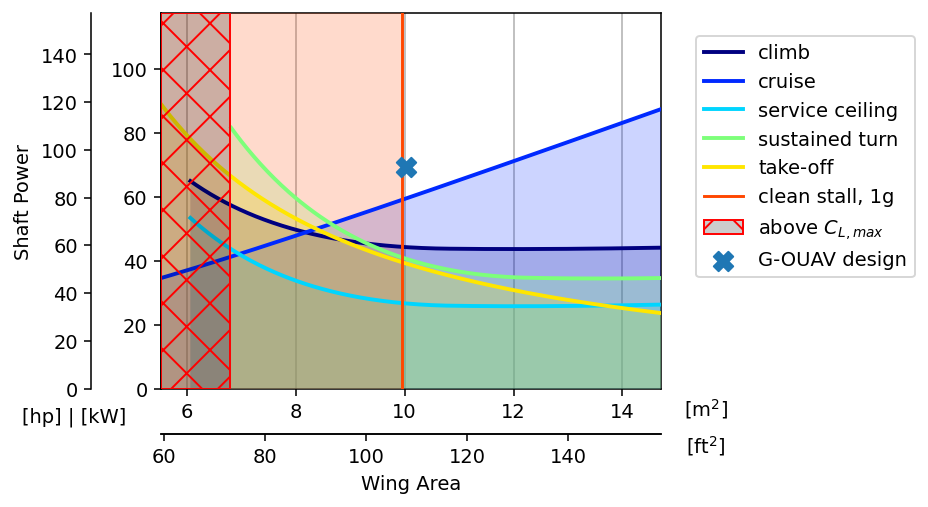

In [8]:
wslist_pa = np.arange(300, 800, 2.5)

fig, ax = concept.plot_constraints(wslist_pa)

scout_power = co.hp2w(93)
scout_Swing = co.feet22m2(108)
ax.scatter(
    scout_Swing, scout_power, label="G-OUAV design",
    marker="X", s=100, zorder=100
)
ax.remake_legend();

# References
<a name="refs"></a>

[1] "Sherwood Scout Pilot's Operating Handbook & Maintenance Manual," The Light Aircraft Company, December 2021. Accessed: 25/12/2023. [Online]. Available: https://www.g-tlac.com/wp-content/uploads/2022/03/Sherwood-Scout-POH-MM-Rev-2-17-12-21.pdf.